In [4]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from dataclasses import dataclass
from typing import List, Dict, Iterable, Literal
import numpy as np

In [33]:
#DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "cpu"
MODEL_NAME = "pysentimiento/robertuito-base-uncased"  # sin fine-tuning

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(DEVICE).eval()

Some weights of RobertaModel were not initialized from the model checkpoint at pysentimiento/robertuito-base-uncased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
def mean_pooling(outputs, attention_mask):
    x = outputs[0]  # last_hidden_state [B, T, H]
    mask = attention_mask.unsqueeze(-1).expand_as(x).float()
    x = (x * mask).sum(1) / mask.sum(1).clamp(min=1e-9)
    return x

In [35]:
@torch.no_grad()
def encode_texts(texts: List[str], batch_size: int = 16, max_length: int = 256) -> torch.Tensor:
    """
    Encoder sin chunking (para textos cortos; lo seguimos usando en prototipos).
    Devuelve shape [N, H], normalizado.
    """
    all_embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to(DEVICE)
        out = model(**enc)
        emb = mean_pooling(out, enc["attention_mask"])
        emb = F.normalize(emb, p=2, dim=1)
        all_embs.append(emb)
    return torch.cat(all_embs, dim=0)

@torch.no_grad()
def build_label_prototypes(emociones: Dict[str, List[str]]) -> Dict[str, torch.Tensor]:
    labels = list(emociones.keys())
    all_prompts = [p for lst in emociones.values() for p in lst]
    prompt_embs = encode_texts(all_prompts, batch_size=16, max_length=64)  # prompts cortos
    protos, k = {}, 0
    for lab in labels:
        n = len(emociones[lab])
        proto = prompt_embs[k:k+n].mean(dim=0, keepdim=True)
        protos[lab] = F.normalize(proto, p=2, dim=1)
        k += n
    return protos

# PARA TEXTOS LARGOS (CHUNKING) ----------------------------

def _ensure_pad_token(tokenizer, model):
    # Si el tokenizer no tiene pad_token, lo asignamos a eos o sep (en RoBERTa suele haber pad=1)
    if tokenizer.pad_token_id is None:
        if tokenizer.eos_token_id is not None:
            tokenizer.pad_token = tokenizer.eos_token
        elif tokenizer.sep_token_id is not None:
            tokenizer.pad_token = tokenizer.sep_token
        else:
            # último recurso: crea un token [PAD] (raro necesitarlo en RoBERTa)
            tokenizer.add_special_tokens({"pad_token": "[PAD]"})
            model.resize_token_embeddings(len(tokenizer))
    # Sincroniza en config
    if getattr(model.config, "pad_token_id", None) != tokenizer.pad_token_id:
        model.config.pad_token_id = tokenizer.pad_token_id

def _get_model_max_len(model, tokenizer) -> int:
    # Máximo real del encoder (posiciones)
    if hasattr(model, "config") and getattr(model.config, "max_position_embeddings", None):
        return int(model.config.max_position_embeddings)
    ml = getattr(tokenizer, "model_max_length", None)
    if ml is not None and ml != float("inf"):
        return int(ml)
    return 512

# --- Split de ids en ventanas internas sin especiales ---
def _split_into_inner_windows(inner_ids: torch.Tensor, inner_len: int) -> List[List[int]]:
    """
    inner_ids: ids SIN especiales (list/tensor 1D)
    Devuelve lista de listas (ids crudos, sin CLS/SEP) de largo <= inner_len.
    """
    L = inner_ids.size(0)
    return [inner_ids[i:i+inner_len].tolist() for i in range(0, L, inner_len)]

# --- Construye lotes de chunks, poniendo especiales con el tokenizer ---
def _build_chunk_batch(batch_inner_lists: List[List[int]], tokenizer, device):
    """
    batch_inner_lists: lista de listas de ids (SIN especiales).
    Usa build_inputs_with_special_tokens para añadir <s> ... </s> correctamente.
    Devuelve input_ids [B, T] y attention_mask [B, T] en device.
    """
    # Añade especiales para cada secuencia
    with_specials = [
        tokenizer.build_inputs_with_special_tokens(inner_list)
        for inner_list in batch_inner_lists
    ]

    # Valida rango de IDs (evita device assert en embedding)
    vocab_size = len(tokenizer)
    for seq in with_specials:
        for tid in seq:
            if tid < 0 or tid >= vocab_size:
                # Si ocurre (no debería), remplaza por unk
                unk = tokenizer.unk_token_id or 0
                idxs_bad = [i for i, x in enumerate(seq) if x < 0 or x >= vocab_size]
                for i in idxs_bad:
                    seq[i] = unk

    # Padding manual
    maxlen = max(len(s) for s in with_specials)
    pad_id = tokenizer.pad_token_id
    input_ids = torch.full((len(with_specials), maxlen), pad_id, dtype=torch.long)
    attn = torch.zeros((len(with_specials), maxlen), dtype=torch.long)
    for r, seq in enumerate(with_specials):
        L = len(seq)
        input_ids[r, :L] = torch.tensor(seq, dtype=torch.long)
        attn[r, :L] = 1

    return input_ids.to(device), attn.to(device)

# --- Encoder con CHUNKING robusto ---
@torch.no_grad()
def encode_long_text(text: str,
                     tokenizer,
                     model,
                     device="cpu",               # prueba en CPU si estás depurando
                     chunk_size: int | None = None,
                     agg: Literal["mean","max"] = "mean",
                     inner_batch: int = 8):
    """
    Devuelve [1, H] usando chunking seguro:
    - Respeta max_len real del modelo
    - Usa build_inputs_with_special_tokens para CLS/SEP
    - Valida rango de IDs
    """
    _ensure_pad_token(tokenizer, model)
    model_max = _get_model_max_len(model, tokenizer)   # p.ej. 130 en tu checkpoint
    # Tamaño target por chunk *incluyendo* especiales
    chunk_with_specials = model_max if (chunk_size is None or chunk_size > model_max) else chunk_size
    inner_len = max(2, chunk_with_specials - 2)  # espacio para CLS/SEP

    # Tokeniza sin truncar y quita especiales para trocear sobre ids “limpios”
    enc = tokenizer(text, return_tensors="pt", truncation=False, add_special_tokens=True)
    ids = enc["input_ids"][0]  # [L]
    # Remueve especiales en extremos si ya venían
    if ids.numel() > 0 and ids[0].item() == tokenizer.cls_token_id:
        ids = ids[1:]
    if ids.numel() > 0 and ids[-1].item() == tokenizer.sep_token_id:
        ids = ids[:-1]

    # Si el texto queda vacío, crea un chunk mínimo
    if ids.numel() == 0:
        ids = torch.tensor([tokenizer.unk_token_id or tokenizer.sep_token_id], dtype=torch.long)

    inner_windows = _split_into_inner_windows(ids, inner_len)

    chunk_embs = []
    for i in range(0, len(inner_windows), inner_batch):
        batch_inner = inner_windows[i:i+inner_batch]
        input_ids, attn = _build_chunk_batch(batch_inner, tokenizer, device)

        out = model(input_ids=input_ids, attention_mask=attn)
        emb = mean_pooling(out, attn)      # [B, H]
        emb = F.normalize(emb, p=2, dim=1)
        chunk_embs.append(emb)

    chunk_embs = torch.cat(chunk_embs, dim=0)  # [num_chunks, H]
    if agg == "mean":
        doc_emb = chunk_embs.mean(dim=0, keepdim=True)
    else:
        doc_emb, _ = chunk_embs.max(dim=0, keepdim=True)

    return F.normalize(doc_emb, p=2, dim=1)

@torch.no_grad()
def encode_long_texts(texts: List[str], tokenizer, model, device="cpu",
                      chunk_size: int | None = None,
                      agg: Literal["mean","max"] = "mean",
                      inner_batch: int = 8):
    embs = []
    for t in texts:
        embs.append(encode_long_text(t, tokenizer, model, device=device,
                                     chunk_size=chunk_size, agg=agg, inner_batch=inner_batch))
    return torch.cat(embs, dim=0)


In [49]:
EMOCIONES = {
    "a) Alegría": [
        "El texto expresa alegría.",
        "El tono es feliz y positivo.",
        "La persona se siente contenta y optimista.",
        "Se percibe entusiasmo y satisfacción.",
        "La emoción principal es la felicidad."
    ],
    "b) Tristeza": [
        "El texto expresa tristeza.",
        "El tono es melancólico o deprimido.",
        "La persona se siente desanimada y sola.",
        "Se nota dolor emocional o pérdida.",
        "Predomina la sensación de desesperanza."
    ],
    "c) Ira": [
        "El texto expresa ira.",
        "El tono es enojado o furioso.",
        "La persona se siente indignada y molesta.",
        "Se percibe frustración y enfado intenso.",
        "La emoción principal es el enojo."
    ],
    "d) Miedo": [
        "El texto expresa miedo.",
        "El tono refleja temor o angustia.",
        "La persona se siente insegura o en peligro.",
        "Se nota ansiedad y preocupación.",
        "Predomina la sensación de amenaza."
    ],
    "e) Sorpresa": [
        "El texto expresa sorpresa.",
        "El tono indica asombro o desconcierto.",
        "La persona se siente impactada e inesperada.",
        "Se percibe admiración o incredulidad.",
        "La emoción principal es el asombro."
    ],
    "f) Vergüenza": [
        "El texto expresa vergüenza.",
        "El tono refleja incomodidad y bochorno.",
        "La persona se siente apenada y expuesta.",
        "Se nota timidez y rubor emocional.",
        "Predomina la sensación de humillación."
    ],
    "g) Culpa": [
        "El texto expresa culpa.",
        "El tono refleja remordimiento o arrepentimiento.",
        "La persona se siente responsable de algo negativo.",
        "Se percibe auto-reproche y vergüenza moral.",
        "Predomina la sensación de arrepentimiento."
    ],
    # "h) Ninguna" se maneja con la regla: si no supera umbral -> Ninguna
}


LABEL_PROTOS = build_label_prototypes(EMOCIONES)
LABELS = list(LABEL_PROTOS.keys())
LABEL_MAT = torch.cat([LABEL_PROTOS[l] for l in LABELS], dim=0)  # [L, H]

In [59]:
@torch.no_grad()
def score_emotions_chunked(texts: List[str],
                           tokenizer, model, device="cpu",
                           chunk_size: int | None = None,
                           agg: Literal["mean","max"] = "mean",
                           inner_batch: int = 8):
    X = encode_long_texts(texts, tokenizer, model, device=device,
                          chunk_size=chunk_size, agg=agg, inner_batch=inner_batch)  # [N, H]
    sims = X @ LABEL_MAT.T  # LABEL_MAT como antes
    return sims

def predict_chunked(texts: List[str],
                    tokenizer, model, device="cpu",
                    umbral: float = 0.32,
                    chunk_size: int | None = None,
                    agg: Literal["mean","max"] = "mean",
                    inner_batch: int = 8,
                    incluir_ninguna: bool = True):
    sims = score_emotions_chunked(texts, tokenizer, model, device=device,
                                  chunk_size=chunk_size, agg=agg, inner_batch=inner_batch)
    preds = []
    for i in range(sims.size(0)):
        row = sims[i].tolist()
        for j, s in enumerate(row):
            print(f"{LABELS[j]}: {s:.4f}")
        labs = [LABELS[j] for j, s in enumerate(row) if s >= umbral]
        if not labs and incluir_ninguna:
            labs = ["h) Ninguna"]
        preds.append(labs)
    return preds


In [60]:
import os
directorio = "./paginas_limpias"
archivos = os.listdir(directorio)
to_delete = ['politica_de_prevencion_de_la_corrupcion.txt', 'politica_de_prevencion_de_la_corrupcion_4.txt', 'politica_de_prevencion_de_la_corrupcion_8.txt']
for f in to_delete:
    if f in archivos:
        archivos.remove(f)
print(len(archivos))

8


In [61]:
texts = []
for f in archivos:
    with open(os.path.join(directorio, f), 'r', encoding='utf-8') as file:
        texts.append(file.read())

In [62]:
preds = predict_chunked(texts,
                        tokenizer, model, device="cpu",
                        umbral=0.5, chunk_size=512,  # se recorta solo si tu modelo no soporta 512
                        agg="mean", inner_batch=8, incluir_ninguna=True)

for t, p in zip(archivos, preds):
    print(f"{t}: {p}")

a) Alegría: 0.4073
b) Tristeza: 0.4377
c) Ira: 0.4060
d) Miedo: 0.4122
e) Sorpresa: 0.4124
f) Vergüenza: 0.4373
g) Culpa: 0.4192
a) Alegría: 0.4900
b) Tristeza: 0.5209
c) Ira: 0.4974
d) Miedo: 0.5147
e) Sorpresa: 0.5171
f) Vergüenza: 0.5305
g) Culpa: 0.5210
a) Alegría: 0.4655
b) Tristeza: 0.4774
c) Ira: 0.4837
d) Miedo: 0.4899
e) Sorpresa: 0.4981
f) Vergüenza: 0.5098
g) Culpa: 0.5050
a) Alegría: 0.4404
b) Tristeza: 0.4315
c) Ira: 0.4287
d) Miedo: 0.4480
e) Sorpresa: 0.4490
f) Vergüenza: 0.4677
g) Culpa: 0.4530
a) Alegría: 0.4791
b) Tristeza: 0.4928
c) Ira: 0.4721
d) Miedo: 0.4887
e) Sorpresa: 0.4875
f) Vergüenza: 0.4927
g) Culpa: 0.4678
a) Alegría: 0.4988
b) Tristeza: 0.5054
c) Ira: 0.4934
d) Miedo: 0.5007
e) Sorpresa: 0.4990
f) Vergüenza: 0.5003
g) Culpa: 0.4944
a) Alegría: 0.4298
b) Tristeza: 0.4247
c) Ira: 0.4124
d) Miedo: 0.4247
e) Sorpresa: 0.4193
f) Vergüenza: 0.4379
g) Culpa: 0.4033
a) Alegría: 0.4105
b) Tristeza: 0.4298
c) Ira: 0.4224
d) Miedo: 0.4359
e) Sorpresa: 0.4477
f) Ver

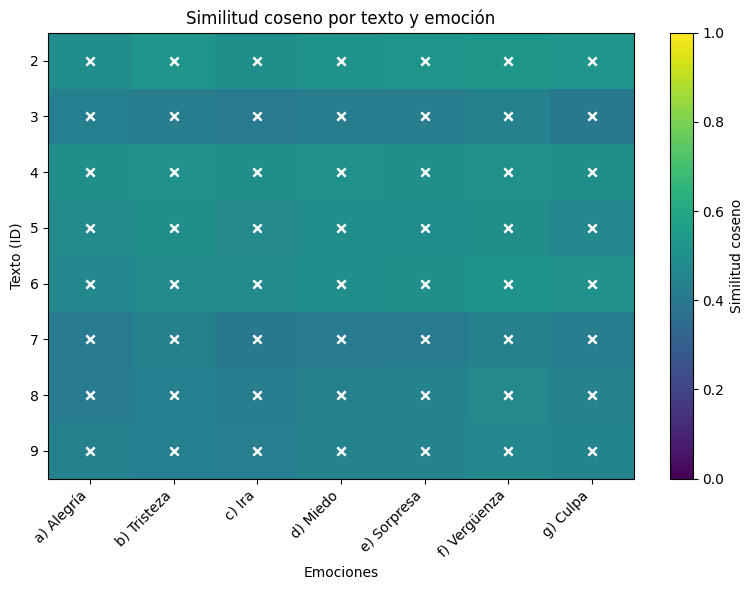

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def compute_sims(texts, tokenizer, model, device="cpu",
                 chunk_size=None, agg="mean", inner_batch=8):
    """
    Solo calcula la matriz de similitudes [N, L] con tus funciones actuales.
    """
    sims = score_emotions_chunked(
        texts, tokenizer, model, device=device,
        chunk_size=chunk_size, agg=agg, inner_batch=inner_batch
    )
    return sims.detach().cpu().numpy()  # a numpy para graficar

import re
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def parse_pages(url_items):
    """
    url_items: lista de strings como
      '1) https://... (Título)'
    Devuelve:
      page_nums: lista de ints [1,2,...]
      row_labels: etiquetas amigables por fila (puedes ajustar a gusto)
    """
    page_nums, row_labels = [], []
    for s in url_items:
        # número de página al inicio: "N)"
        m = re.match(r'^\s*(\d+)\)\s*(.*)', s)
        if not m:
            # sin número, lo mandamos al final
            page_nums.append(10**9)
            row_labels.append(s)
            continue
        n = int(m.group(1))
        rest = m.group(2)
        # etiqueta corta: "N) dominio" o "N) título"
        # extrae dominio si hay URL
        dom = None
        murl = re.search(r'https?://([^/\s)]+)', rest)
        if murl:
            dom = murl.group(1)
        label = f"{n}) {dom}" if dom else f"{n})"
        page_nums.append(n)
        row_labels.append(label)
    return page_nums, row_labels

def build_heatmap_data(sims_np, labels, url_items, umbral=0.32, to_percent=True):
    """
    sims_np: matriz N×L de cosenos ([-1,1])
    labels: lista de emociones (columnas)
    url_items: lista de strings con 'N) ...' del mismo largo que N
    umbral: umbral sobre el valor de similitud (si to_percent=True, se reescala también)
    to_percent: si True, mapea coseno [-1,1] -> [0,100]
    Devuelve:
      data: matriz N×L lista para imshow
      mask_over: posiciones donde data >= umbral (re-escalado si aplica)
      row_labels_ordenadas, labels (columnas), order_idx
    """
    # 1) orden de páginas por número
    page_nums, row_labels = parse_pages(url_items)
    order_idx = np.argsort(page_nums)  # ordena por número
    sims_ord = sims_np[order_idx]

    # 2) re-escalar a porcentaje 0..100 si se desea
    if to_percent:
        data = ((sims_ord + 1.0) / 2.0) * 100.0
        thr_val = ((umbral + 1.0) / 2.0) * 100.0
        vmin, vmax = 0, 100
        cbar_label = "Similitud (0–100)"
    else:
        data = sims_ord
        thr_val = umbral
        vmin, vmax = -1.0, 1.0
        cbar_label = "Similitud coseno"

    # 3) máscara de celdas que superan el umbral
    mask_over = data >= thr_val

    # 4) etiquetas de filas ordenadas
    row_labels_ord = [row_labels[i] for i in order_idx]

    return data, mask_over, row_labels_ord, labels, (vmin, vmax), cbar_label

def plot_similarity_heatmap(sims_np,
                            labels,
                            url_items,
                            umbral=0.32,
                            to_percent=True,
                            figsize=(12,6),
                            out_path=None):
    """
    Dibuja heatmap N×L (páginas × emociones) con X donde supera umbral.
    """
    data, mask_over, row_labels_ord, col_labels, (vmin, vmax), cbar_label = \
        build_heatmap_data(sims_np, labels, url_items, umbral=umbral, to_percent=to_percent)

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()

    im = ax.imshow(data, aspect='auto', vmin=vmin, vmax=vmax, cmap="viridis")

    # marcas "X" sobre celdas que superan umbral
    ys, xs = np.where(mask_over)
    ax.scatter(xs, ys, s=60, c='w', marker='x', linewidths=2)

    # ticks y etiquetas
    ax.set_xticks(np.arange(len(col_labels)))
    ax.set_xticklabels(col_labels, rotation=45, ha='right')
    ax.set_yticks(np.arange(len(row_labels_ord)))
    ax.set_yticklabels(row_labels_ord)

    ax.set_xlabel("Emociones")
    ax.set_ylabel("Página")
    ax.set_title("Similitud texto ↔ prototipos de emoción")

    # colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(cbar_label)

    plt.tight_layout()
    if out_path:
        Path(out_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_path, dpi=150)
        plt.close(fig)
    else:
        plt.show()

file_dict = {'2': 'ficha_limpia_entre_la_hipocresia_y_una_sociedad_sobreadaptada_a_la_corrupcion_la_nacion.txt',
             '3': 'corrupcion.txt',
             '4': 'controlar_la_corrupcion_no_es_opcional.txt',
             '5': 'por_que_es_indispensable_romper_el_circulo_vicioso_de_la_corrupcion_aunque_sea_dificil_ifac.txt',
             '6': 'el_descontrol_genera_ilegalidades_y_corrupcion_cuba_granma_organo_oficial_del_pcc.txt',
             '7': 'quito_honesto.txt',
             '8': 'asamblea_legislativa_de_el_salvador.txt',
             '9': 'politica_de_prevencion_de_la_corrupcion_2.txt'}

fname2num = {v: k for k, v in file_dict.items()}

# Construimos los nombres de fila con números si existe mapeo, si no el filename
row_labels = [fname2num.get(f, f) for f in archivos]

# (opcional) ordena por número creciente si todas (o la mayoría) son números
def _as_int_or_inf(x):
    try:
        return int(x)
    except:
        return 10**9  # los que no sean número, al final

order_idx = sorted(range(len(row_labels)), key=lambda i: _as_int_or_inf(row_labels[i]))
row_labels_sorted = [row_labels[i] for i in order_idx]

sims_np = compute_sims(texts, tokenizer, model, device="cpu", chunk_size=None, agg="mean", inner_batch=8)
assert sims_np.shape[0] == len(archivos), "sims_np y 'archivos' no alinean en número de textos."
sims_np_sorted = sims_np[order_idx, :]

import numpy as np
import matplotlib.pyplot as plt

def plot_similarity_heatmap(sims_np, row_labels, col_labels, umbral=None, vmin=-1.0, vmax=1.0):
    """
    sims_np: np.ndarray [N, L] con cosenos.
    row_labels: lista de N etiquetas (números o nombres de textos).
    col_labels: lista de L emociones (LABELS).
    umbral: si se da, marca con 'x' las celdas >= umbral.
    vmin, vmax: rango de la escala del coseno para el colormap.
    """
    N, L = sims_np.shape
    fig = plt.figure(figsize=(max(8, L*0.9), max(6, N*0.4)))  # escala razonable
    ax = plt.gca()

    im = ax.imshow(sims_np, aspect='auto', vmin=vmin, vmax=vmax, cmap="viridis")

    # ticks y etiquetas
    ax.set_xticks(np.arange(L))
    ax.set_xticklabels(col_labels, rotation=45, ha='right')
    ax.set_yticks(np.arange(N))
    ax.set_yticklabels(row_labels)

    ax.set_xlabel("Emociones")
    ax.set_ylabel("Texto (ID)")
    ax.set_title("Similitud coseno por texto y emoción")

    # colorbar
    cb = plt.colorbar(im, ax=ax)
    cb.set_label("Similitud coseno")

    # marcar celdas >= umbral con 'x' (opcional)
    if umbral is not None:
        ys, xs = np.where(sims_np >= umbral)
        ax.scatter(xs, ys, s=36, c='w', marker='x', linewidths=1.8)

    # cuadrícula suave (opcional)
    ax.set_ylim(N-0.5, -0.5)
    plt.tight_layout()
    plt.show()

# Llama a la función con la versión reordenada
plot_similarity_heatmap(
    sims_np_sorted,
    row_labels_sorted,
    LABELS,        # tus emociones (mismo orden que LABEL_MAT)
    umbral=0.32,   # opcional
    vmin=0, vmax=1.0
)
